In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Retinal Vessel Segmentation')

In [6]:
from LadderNet import *

In [12]:
from models import *

In [1]:
###################################################
#
#   Script to pre-process the original imgs
#
##################################################
#change np.empty to np.zeros
import numpy as np
from PIL import Image
import cv2,sys

def readImg(im_fn):
    im = Image.open(im_fn)
    return im

#convert RGB to Grayscale image
def rgb2gray(rgb):
    assert (len(rgb.shape)==4)  #4D arrays
    assert (rgb.shape[1]==3)
    gray_imgs = rgb[:,0,:,:]*0.299 + rgb[:,1,:,:]*0.587 + rgb[:,2,:,:]*0.114
    gray_imgs = np.reshape(gray_imgs,(rgb.shape[0],1,rgb.shape[2],rgb.shape[3]))
    return gray_imgs
    
#histogram equalization
def histo_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_equalized = np.zeros(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = cv2.equalizeHist(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    #create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.zeros(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = clahe.apply(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized

#normalize over the dataset
def dataset_normalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.zeros(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    #Mean & Std-Deviation Normalization
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    #Min - Max Normalization
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized

#Gamma Correction
def adjust_gamma(imgs, gamma=1.0):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.zeros(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i,0] = cv2.LUT(np.array(imgs[i,0], dtype = np.uint8), table)
    return new_imgs

#My pre processing 
def my_PreProc(img_path,save_path,idx):
    data = np.asarray(Image.open(img_path)) 
    data = np.flip(data,axis=2)  # BGR to RGB
    data = np.expand_dims(data,axis=0)
    data = np.transpose(data,(0,3,1,2)) # (N,C,H,W)
    assert (len(data.shape)==4)
    assert (data.shape[1]==3)  #Use the original images
    #black-white conversion
    train_imgs = rgb2gray(data)
    cv2.imwrite(save_path+'/img_gray_{}.png'.format(idx), train_imgs[0,0])
    
    train_imgs = dataset_normalized(train_imgs)
    cv2.imwrite(save_path+'/img_normalized_{}.png'.format(idx), train_imgs[0,0])

    train_imgs = clahe_equalized(train_imgs)
    cv2.imwrite(save_path+'/img_clahe_{}.png'.format(idx), train_imgs[0,0])

    train_imgs = adjust_gamma(train_imgs, 1.2)
    cv2.imwrite(save_path+'/img_gamma_{}.png'.format(idx), train_imgs[0,0])

    train_imgs = train_imgs/255.

    return train_imgs

# if __name__ == "__main__":
#     img_path = '/ssd/lzq/sf3/data/STARE/images/im0005.ppm'
#     save_path = '/ssd/lzq/sf3/visualization/preprocess_visual_result'
#     my_PreProc(img_path,save_path,idx=5)

In [2]:
import numpy as np
from PIL import Image
import cv2,sys
import matplotlib.pyplot as plt

def readImg(im_fn):
    im = Image.open(im_fn)
    return im

path_img = "/content/drive/MyDrive/Retinal Vessel Segmentation/Datasets/DRIVE/training/images/22_training.tif"
path_man = "/content/drive/MyDrive/Retinal Vessel Segmentation/Datasets/DRIVE/training/1st_manual/22_manual1.gif"
path_mask = "/content/drive/MyDrive/Retinal Vessel Segmentation/Datasets/DRIVE/training/mask/22_training_mask.gif"

In [3]:
img = np.asarray(readImg(path_img))
manual = np.asarray(readImg(path_man))

img = np.flip(img,axis=2)
img = np.expand_dims(img,axis=0)
img = np.transpose(img,(0,3,1,2))
train_imgs = rgb2gray(img)

img.shape, train_imgs.shape

((1, 3, 584, 565), (1, 1, 584, 565))

In [4]:
train_imgs = dataset_normalized(train_imgs)
#train_imgs = histo_equalized(train_imgs)
train_imgs = clahe_equalized(train_imgs)
train_imgs = adjust_gamma(train_imgs, 1.2)
train_imgs = train_imgs/255.



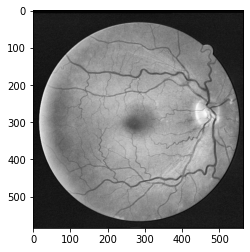

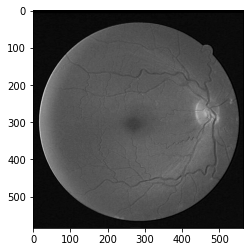

In [84]:
plt.imshow(train_imgs[0,0,:,:], cmap="gray")
plt.show()
plt.imshow(img[0,0,:,:], cmap="gray")
plt.show()

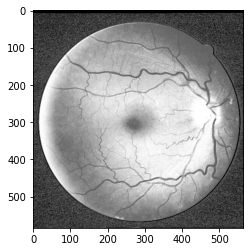

In [5]:
plt.imshow(train_imgs[0,0,:,:], cmap="gray")
plt.show()

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.get_device_name(0)

'Tesla T4'